# lab_02 - Wprowadzenie do biblioteki Dask.

## 1. Krótki opis biblioteki Dask.

Dask jest zbiorem rozwiązań, który pozwala na zrównoleglenie obliczeń w języku Python oraz przetwarzanie zbiorów większych niż dostępna pamięć RAM. Ekosystem Dask składa się z wielu elementów. 

**Kolekcje Dask (Dask collections):**
* Kolekcje wysokiego poziomu
  * Dask Dataframe
  * Dask Array
  * Dask Bag
* Niskopoziomowe kolekcje
  * Dask Dalayed & Futures

**Klaster Dask**

**Inne elementy ekosystemu Dask:**

* Dask-ML (parallel scikit-learn-style API)
* Dask-image
* Dask-cuDF
* Dask-sql
* Dask-snowflake
* Dask-mongo
* Dask-bigquery


![dask overwiev](dask-overview.svg)


_źródło: dask.org_

**Instalacja Dask**

Oficjalna dokumentacja: https://docs.dask.org/en/stable/install.html

Instalacja podstawowej biblioteki Dask jest bardzo prosta:

```bash
python -m pip install dask
```

Dask posiada jednak duży zbiór opcjonalnych modułów, które mogą się przydać w zależności od potrzeb i zakresu serwisów oraz źródeł danych, z których chcemy skorzystać. Można więc zainstalować również wszystko bez zwracania uwagi na szczegóły:

```bash
python -m pip install dask[complete]
```

Szczegóły instalowanych zależności i ich zastosowanie znajduje się w oficjalnej dokumentacji.

## 2. Dask DataFrame.

> **Oficjalna dokumentacja:** https://docs.dask.org/en/latest/dataframe.html

Ramka Dask jest bardzo zbliżona do ramki pandas w kontekście obsługi z poziomu programisty. Główne różnice są ukryte w sposobie jej przechowywania i wykonywania obliczeń. Obliczenia odbywają się w sposób rozproszony i zrównoleglony.
Dask DataFrame składa się z wielu ramek pandas, odpowiednio podzielonych, aby można było zarówno dane jak i obliczenia wykonać na wielu węzłach (ang. worker) jednocześnie.


![dask_dataframe](dask-dataframe.svg)
_źródło: dask.org_

In [1]:
# obserwuj komunikaty, aby zainstalować ewentualnie brakujące komponenty
# w komórce wynikowej notebooka pojawi się link do dashboardu, w którym można obserwować aktualne
# zadania i obciążenie klastra jak i zadania wykonane
# UWAGA! Po doinstalowaniu biblioteki bokeh może być konieczne zrestartowanie jądra Pythona i całego notebooka
# aby dashboard poprawnie działał. Każde kolejne uruchomienie poniższego kodu bez restartu jądra, utworzy nową
# instancję klienta

from dask.distributed import Client

client = Client(n_workers=4)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 4
Total threads: 12,Total memory: 31.91 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:62616,Workers: 4
Dashboard: http://127.0.0.1:8787/status,Total threads: 12
Started: Just now,Total memory: 31.91 GiB
Comm: tcp://127.0.0.1:62636,Total threads: 3
Dashboard: http://127.0.0.1:62641/status,Memory: 7.98 GiB
Nanny: tcp://127.0.0.1:62619,


2024-10-09 13:44:53,506 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f2de02a23dfbe251adbb1166c2790388 initialized by task ('shuffle-transfer-f2de02a23dfbe251adbb1166c2790388', 15) executed on worker tcp://127.0.0.1:62635
2024-10-09 13:44:55,938 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f2de02a23dfbe251adbb1166c2790388 deactivated due to stimulus 'task-finished-1728474295.9377942'
2024-10-09 13:45:43,119 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f2de02a23dfbe251adbb1166c2790388 initialized by task ('shuffle-transfer-f2de02a23dfbe251adbb1166c2790388', 16) executed on worker tcp://127.0.0.1:62638
2024-10-09 13:45:45,784 - distributed.shuffle._scheduler_plugin - WARNING - Shuffle f2de02a23dfbe251adbb1166c2790388 deactivated due to stimulus 'task-finished-1728474345.7838187'


Powyższy kod uruchamia instancję lokalnego klastra, który określna 4 workery, między które będzie rozdzielana praca do wykonania. Konfiguracja tego klastra jest tutaj zredukowana do minimum, gdyż bardziej szczegółowo zostanie to omówione na kolejnych zajęciach. Warto tu wiedzieć, że możemy określić czy zadania będą uruchamiane w ramach nowych procesów, czy wątków. Możemy również wskazać ile wątków na worker przypadnie jeżeli na wątki się zdecydujemy. Możemy również określić limit pamięci na worker, co jest dobrym pomysłem gdyż pozostawienie tego parametru z wartością domyślną rozdzieli pamięć po równo na każdy z workerów. Warto pozostawić systemowi hosta trochę zasobów (można sprawdzić wcześniej ile zasobów zużywa system "na jałowym biegu").

Szczegóły API dla lokalnego klastra znajdziemy tu: https://distributed.dask.org/en/latest/api.html#distributed.LocalCluster

W celu pogłębienia wiedzy o niskopoziomowych niuansach działania Pythona, a szczególnie w kontekście współbieżności (lub jej braku) zachęcam do oglądnięcia wystąpienia Marcina Kawki pod tytułem "Wątki i procesy, czyli o zrównoleglaniu programów w Pythonie" na Pytech Summit 2022. Film dostępny pod adresem: https://www.youtube.com/watch?v=kRy_UwUhBpo

Więcej szczegółów oraz film z wprowadzeniem do dashboardu Dask znajdziesz pod adresem: https://docs.dask.org/en/stable/dashboard.html

In [33]:
client.scheduler_info

<bound method Client.scheduler_info of <Client: 'tcp://127.0.0.1:62616' processes=4 threads=12, memory=31.91 GiB>>

In [2]:
import os
import dask

In [3]:
import dask.dataframe as dd


# dane, które są przykładowe i nie są dołączone do notebooka
# to dane, które ze zbioru zamowienia.csv zostały sztucznie zwielokrotnione, podzielone i zapisane w kilku
# plikach .csv
ddf = dd.read_csv(os.path.join("..", "lab_01", "data", "*.csv"))

In [4]:
ddf

,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
npartitions=20,,,,,
,string,string,string,int64,float64
,...,...,...,...,...
...,...,...,...,...,...
,...,...,...,...,...
,...,...,...,...,...


Dask nie wykonuje operacji w sposób, do którego możemy być przyzwyczajeni. Tutaj mamy do czynienia z mechnizmem leniwym (ang. lazy), a tym przypadku _lazy loading_, gdzie dask sprawdził ile plików jest do wczytania, podzielił pracę na 20 części oraz na podstawie kilku pierwszych linii z pierwszego pliku ustawił nagłówki kolumn i założył typy danych (które w momencie wystąpienia niespójności w kolumnach mogą ulec zmianie).

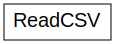

In [5]:
ddf.visualize()

Aby faktycznie wywołać obliczenia musimy wywołać metodę `.compute()` lub jedną z metod, która ją wywołuje niejawnie np. `len`, `head`, `tail`.

In [6]:
# przed uruchomieniem bieżącej komórki ustaw kartę przeglądarki z dashboardem tak, aby byłą również widoczna
# będzie można śledzić pracę klastra

ddf.head()

,Kraj,Sprzedawca,Data zamowienia,idZamowienia,Utarg
0,Niemcy,Leverling,2005-04-20,11004,295.38
1,Polska,Dudek,2004-01-02,10771,344.00
2,Polska,King,2004-09-15,10661,562.60
3,Niemcy,Peacock,2004-05-15,10526,1151.40
4,Niemcy,Leverling,2003-08-12,10273,2037.28


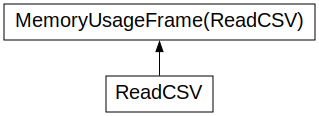

In [7]:
# podobnie jak na zajęciach poprzednich możemy sprawdzić ilość pamięci niezbędnej do przechowania danych ramki
# pamiętajmy o mechanizmie leniwego wywołania, który przygotuje graf obliczeń, ale ich faktycznie jeszcze nie wykona
ddf.memory_usage(deep=True).visualize()

In [8]:
# ponownie można śledzić zadania w dashboardzie
ddf.memory_usage(deep=True).compute()

Index                    2640
Kraj               2516850000
Sprzedawca         2668100000
Data zamowienia    2676650000
idZamowienia        319600000
Utarg               319600000
dtype: int64

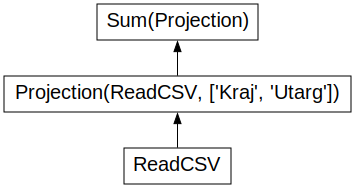

In [9]:
utarg_sum = ddf.groupby(['Kraj']).Utarg.sum()
utarg_sum.visualize()

In [11]:
%%time
utarg_sum.compute()

CPU times: total: 766 ms
Wall time: 5.52 s


Kraj
Niemcy    4.474982e+10
Polska    1.666655e+10
Name: Utarg, dtype: float64

Obliczenia odbywają się w sposób rozproszony i w zależności od wielkości zbioru danych oraz ilości workerów, może zająć więcej czasu niż wykonanie obliczeń lokalnie, jeżeli wybrana porcja danych zmieściłaby się pamięci operacyjnej. Możliwe jest wykonanie operacji zapisania dask dataframe w pamięci w celu przyspieszenia obliczeń na mniejszych fragmentach zbioru. Do zapisania danych w pamięci RAM wykorzystujemy metodę `.persist()`.

In [12]:
polska = ddf[ddf['Kraj'] == 'Polska']

In [13]:
%%time
# obliczenia w sposób load and select (Dask usuwa z pamięci dane będące obliczeniami pośrednimi z grafu,
# stąd nie może ich ponownie wykorzystać jeżeli obliczenia są takie same)
polska['Utarg'].sum().compute()

CPU times: total: 641 ms
Wall time: 4.99 s


np.float64(16666545500.0)

In [14]:
# zapisanie w pamięci RAM
polska = polska.persist()

In [16]:
%%time
# obliczenia w sposób rozproszony
polska['Utarg'].sum().compute()

CPU times: total: 62.5 ms
Wall time: 61 ms


np.float64(16666545500.0)

## 3. Dask Array.

Tablice Dask są skonstruowane wedle takiej samej idei jak ramki danych. Są to struktury, które wewnątrz składają się z wielu tablic numpy, które są wynikiem podzielenia oryginalj tablicy na mniejsze części, aby zrównoleglić i rozproszyć obliczenia.



![dask array](dask-array.svg)

_źródło: dask.org_

In [17]:
import numpy as np
import dask.array as da

Tablica numpy oraz obliczenie średniej z tej tablicy wartości próbkowanych z rozkładu normalnego o danych parametrach.

In [18]:
%%time
arr = np.random.normal(5, 0.2, size=(20_000, 20_000))
arr_mean = arr.mean(axis=0)
arr_mean

CPU times: total: 11.3 s
Wall time: 10.1 s


array([4.99888344, 4.9981054 , 4.99887307, ..., 5.00049768, 5.00209148,
       4.99879029])

Teraz ta sama operacja z wykorzystaniem tablicy Dask.

In [21]:
# tutaj określimy wielkość chunka ręcznie
darr = da.random.normal(5, 0.2, size=(20_000, 20_000), chunks=(2000, 2000))
darr

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(2000, 2000), chunktype=numpy.ndarray>

In [22]:
darr_mean = darr.mean(axis=0)
darr_mean

dask.array<mean_agg-aggregate, shape=(20000,), dtype=float64, chunksize=(2000,), chunktype=numpy.ndarray>

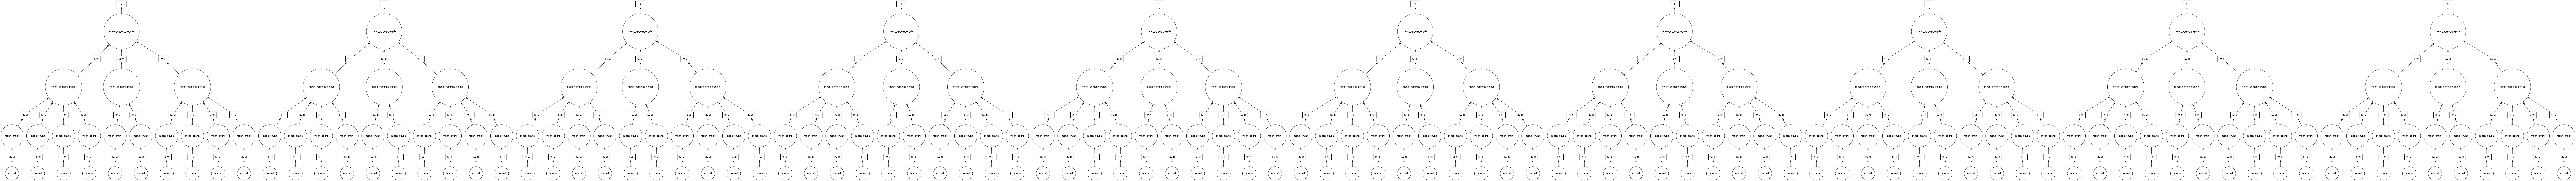

In [23]:
# uwaga z wywolaniem dla dużej liczby chunków tablicy dask!
darr_mean.visualize()

In [27]:
%%time
darr_mean.compute()

CPU times: total: 688 ms
Wall time: 2 s


array([5.00013445, 4.99942839, 4.99994857, ..., 5.00087631, 4.99897009,
       4.99805475])

In [28]:
# stworzenie tej samej tablicy i przekazanie daskowi zadania automatycznego określenia
# wielkości chunka
darr = da.random.normal(5, 0.2, size=(20_000, 20_000))
darr

dask.array<normal, shape=(20000, 20000), dtype=float64, chunksize=(4096, 4096), chunktype=numpy.ndarray>

Dask przydzielił ilość i wielkość chunków, która bardziej odpowiada architekturze komputerów (system dwójkowy) niż systemowi, w którym człowiek czuje się lepiej (system dziesiętny).
Więcej o tym mechanizmie można doczytać tu: https://docs.dask.org/en/stable/array-chunks.html#automatic-chunking, a kilka sprawdzonych porad co do ich wielkości można również znaleźć tutaj: https://tutorial.dask.org/02_array.html#Rules-of-thumb

In [31]:
%%time
darr.mean(axis=0).compute()

CPU times: total: 250 ms
Wall time: 1.84 s


array([4.9978355 , 5.00082559, 4.99896977, ..., 4.99936513, 5.00209992,
       5.00054447])

## **Zadania**

**Zadanie 1**  
Wczytaj plik `zamowienia.csv` do ramki pandas, a następnie w kilku miejscach (ale nie w pierwszych 10 wierszach) wstaw wartość NaN, aby zasymulować wartości brakujące. Zapisz ramkę do pliku `zamowienia_missing.csv`. Wczytaj teraz plik do ramki Dask i sprawdź jakie typy danych zostały przydzielone. Czy zgadzają się z typami z oryginalnego pliku? Wykonaj dowolne obliczenia na całej ramce Dask, aby wymusić wywołanie `.compute()`. Czy pojawił się błąd dotyczący niespójności typów danych? Spróbuj uruchomić kilka razy funkcję wczytywania danych do ramki Dask dataframe z różnymi wartościami parametru `samples`. Dokumentacja `dask.dataframe.read_csv()`: https://docs.dask.org/en/stable/generated/dask.dataframe.read_csv.html

**Zadanie 2**  
Ze strony https://docs.dask.org/en/stable/dashboard.html skonfiguruj plugin Dask dashboard dla Jupyter Lab i przetestuj jego działanie.

**Zadanie 3**  
Skonfiguruj lokalny klaster (`Client`) tak, aby nie zaalokował wszystkich zasobów (np. zostaw 8 GB RAM dla systemu hosta + 2 rdzenie). Pobierz dane udostępnione na poprzednich zajęciach (https://huggingface.co/datasets/vargr/private_instagram/tree/refs%2Fconvert%2Fparquet/default/train) i załaduj do ramki Dask tyle części ile zdołasz w formie bez optymalizacji. Zmierz czas tej operacji. 

**Zadanie 4**  
Wykonaj kilka operacji na klastrze lokalnym z danymi z zadania 3:
* wyświetl top 10 użytkowników z najwyższą liczbą like'ów,
* pobierz dane tylko za pierwsze półrocze 2019 roku.
Każdorazowo zmierz i wyświetl czas operacji i obserwuj dashboard.

**Zadanie 5**  
Wczytaj te same dane do ramki Dask co w zadaniu 3, ale podaj typy danych, które zostały wybrane w procesie optymalizacji wykonanej w zadaniach z lab 01. Porównaj czas ładowania z zadaniem 3. Wykonaj również te same operacje co w zadaniu 4 i porównaj czas. Śledź wykonanie zadań patrząć na graf wywołań.

**Zadanie 6**  
Podziel tablicę `darr` z przykładów na inne liczby chunków (eksperymentuj) i wykonaj te same obliczenie (średnia). Dla każdej liczby chunków wypisz czas obliczeń (wykonaj to samo obliczenie minimum 10 razy, aby nieco uwiarygodnić wyniki i uśrednij) i porównaj wyniki. Napisz wniosek o wynikach swoich eksperymentów i automatycznego podziału na chunki. Czy udało Ci się osiągnąć lepszą wydajność niż przy domyślnych ustawieniach?